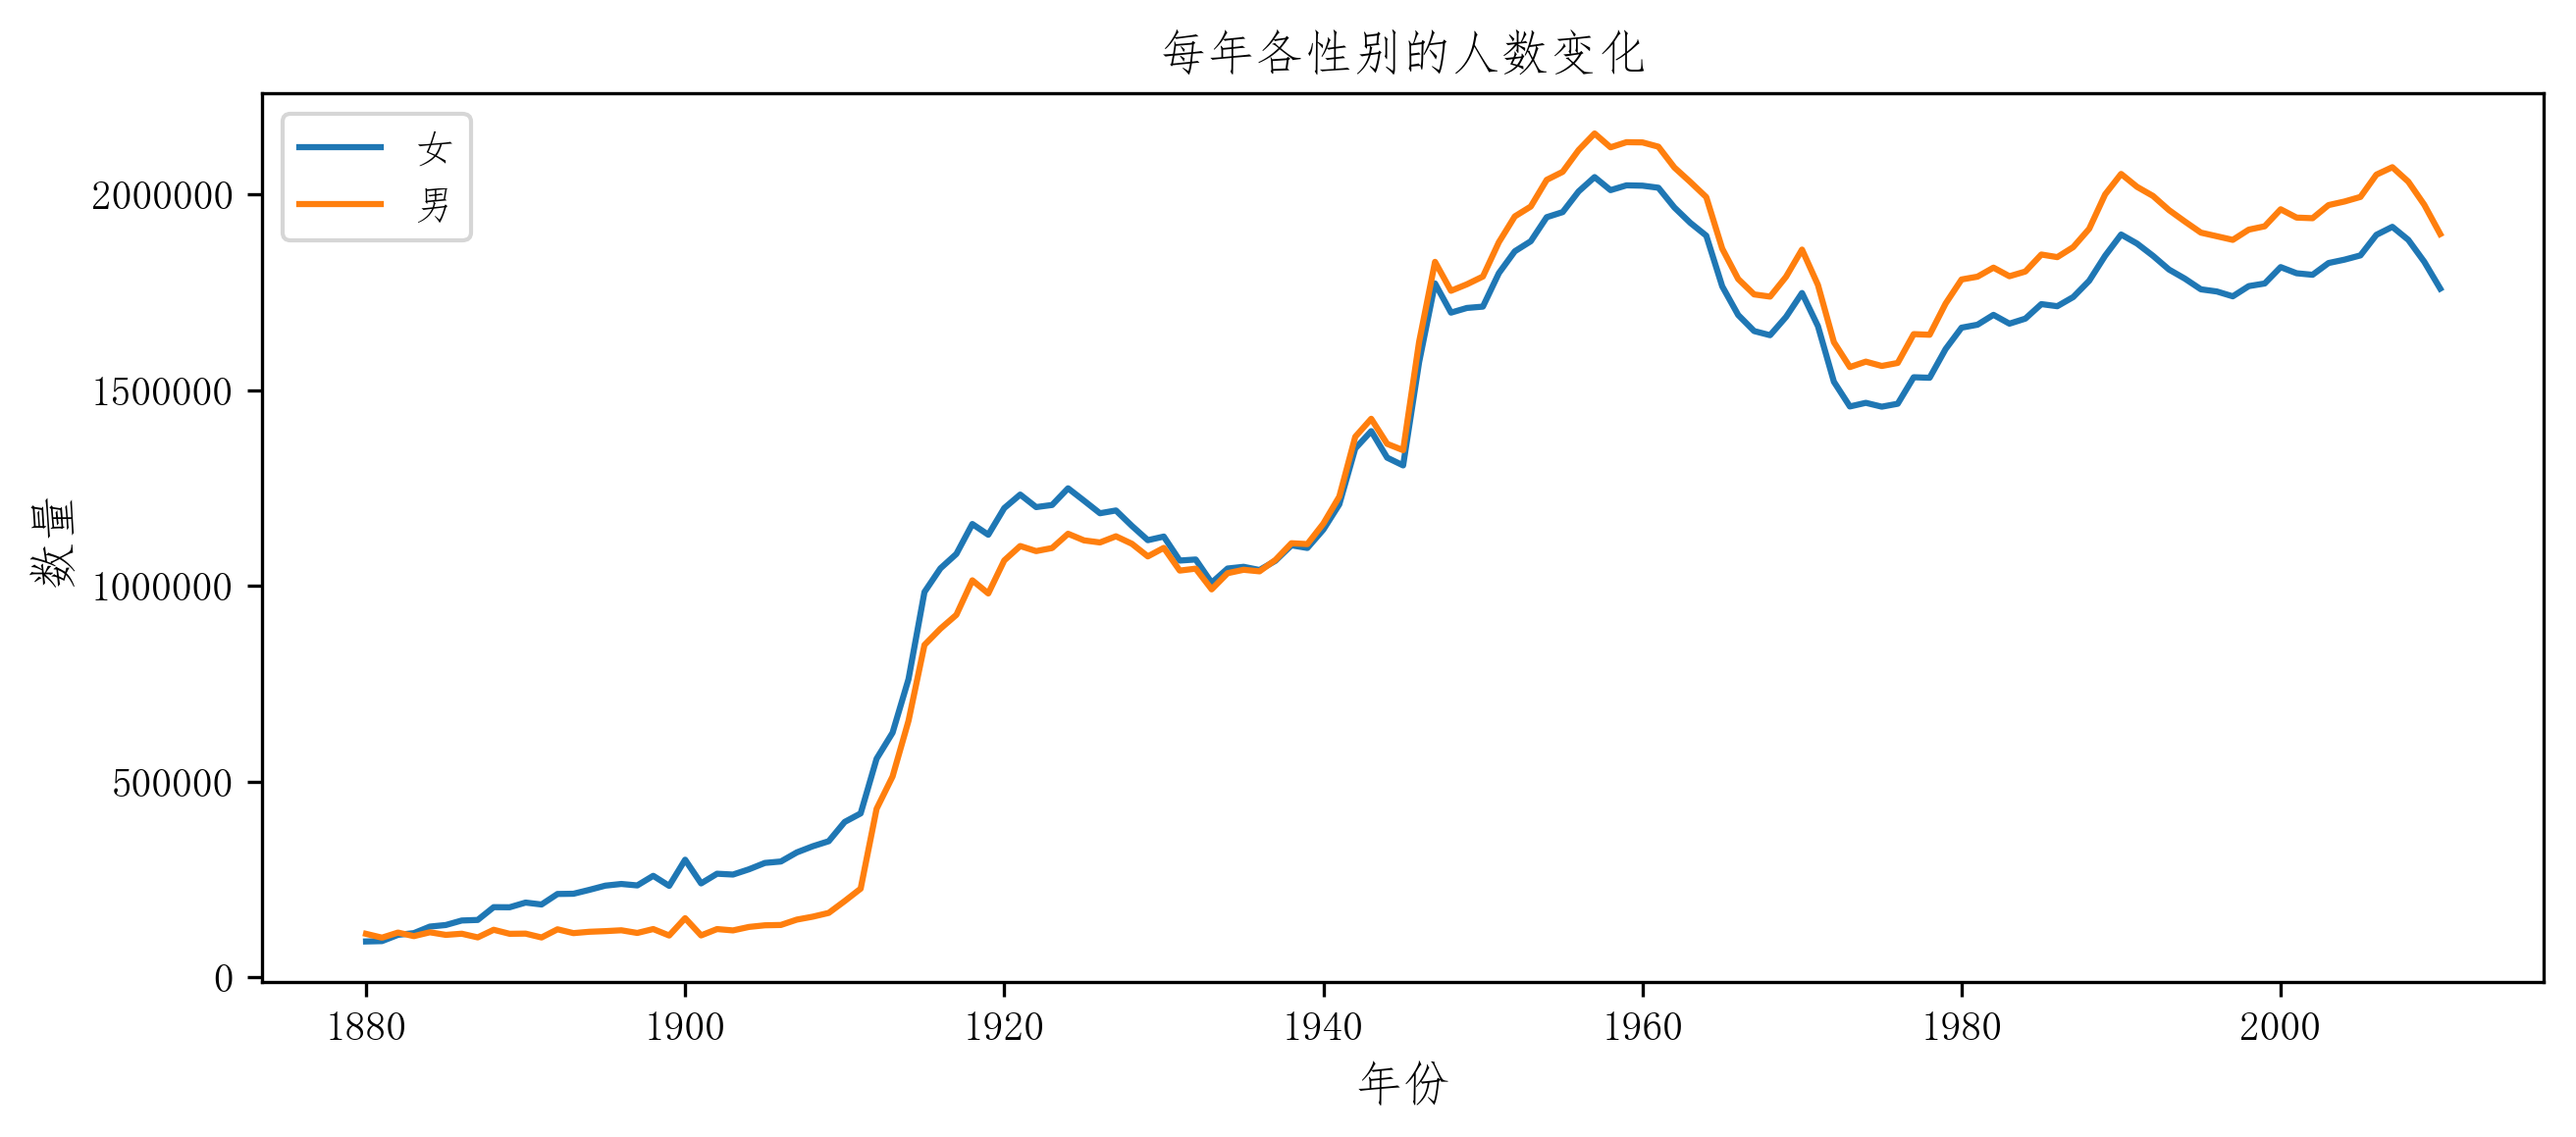

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyecharts import Line
import os
import jieba
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

plt.rcParams['figure.figsize'] = (15.0, 10.0)

os.chdir('C:/数据分析/美国婴儿')

#将所有年的姓名数据整合到一个大的Dataframe中
years=range(1880,2011)
pieces=[]
columns=['name','sex','births']
for year in years:
    path='./babynames/yob%d.txt'%year
    frame=pd.read_csv(path,names=columns)
    frame['year']=year
    pieces.append(frame)
    
names=pd.concat(pieces,ignore_index=True)

#计算每一年男女出生的总人数
total_births=names.pivot_table('births',index='year',columns='sex',aggfunc=sum)
total_births.plot(kind='line',title='每年各性别的人数变化')
plt.legend(labels = ['女', '男'], loc = 'best')
plt.xlabel(u"年份",fontsize=12)
plt.ylabel(u"数量",fontsize=12)
plt.show()





In [46]:
#将每一年中每个姓名的人数转化为百分比
def add_prop(group):
    group['prop']=group.births/group.births.sum()
    return group

names=names.groupby(['year','sex']).apply(add_prop)

#做数据的有效性检查
names.groupby(['year','sex']).prop.sum()

In [47]:
#进一步分析，取出该数据的一个子集，即每对sex/year组合数量排名前1000的名字

def get_top1000(group):
    return group.sort_values(by='births',ascending=False)[:1000]

grouped=names.groupby(['year','sex'])
top1000=grouped.apply(get_top1000)
#删除分组的标签
top1000.reset_index(inplace=True,drop=True)

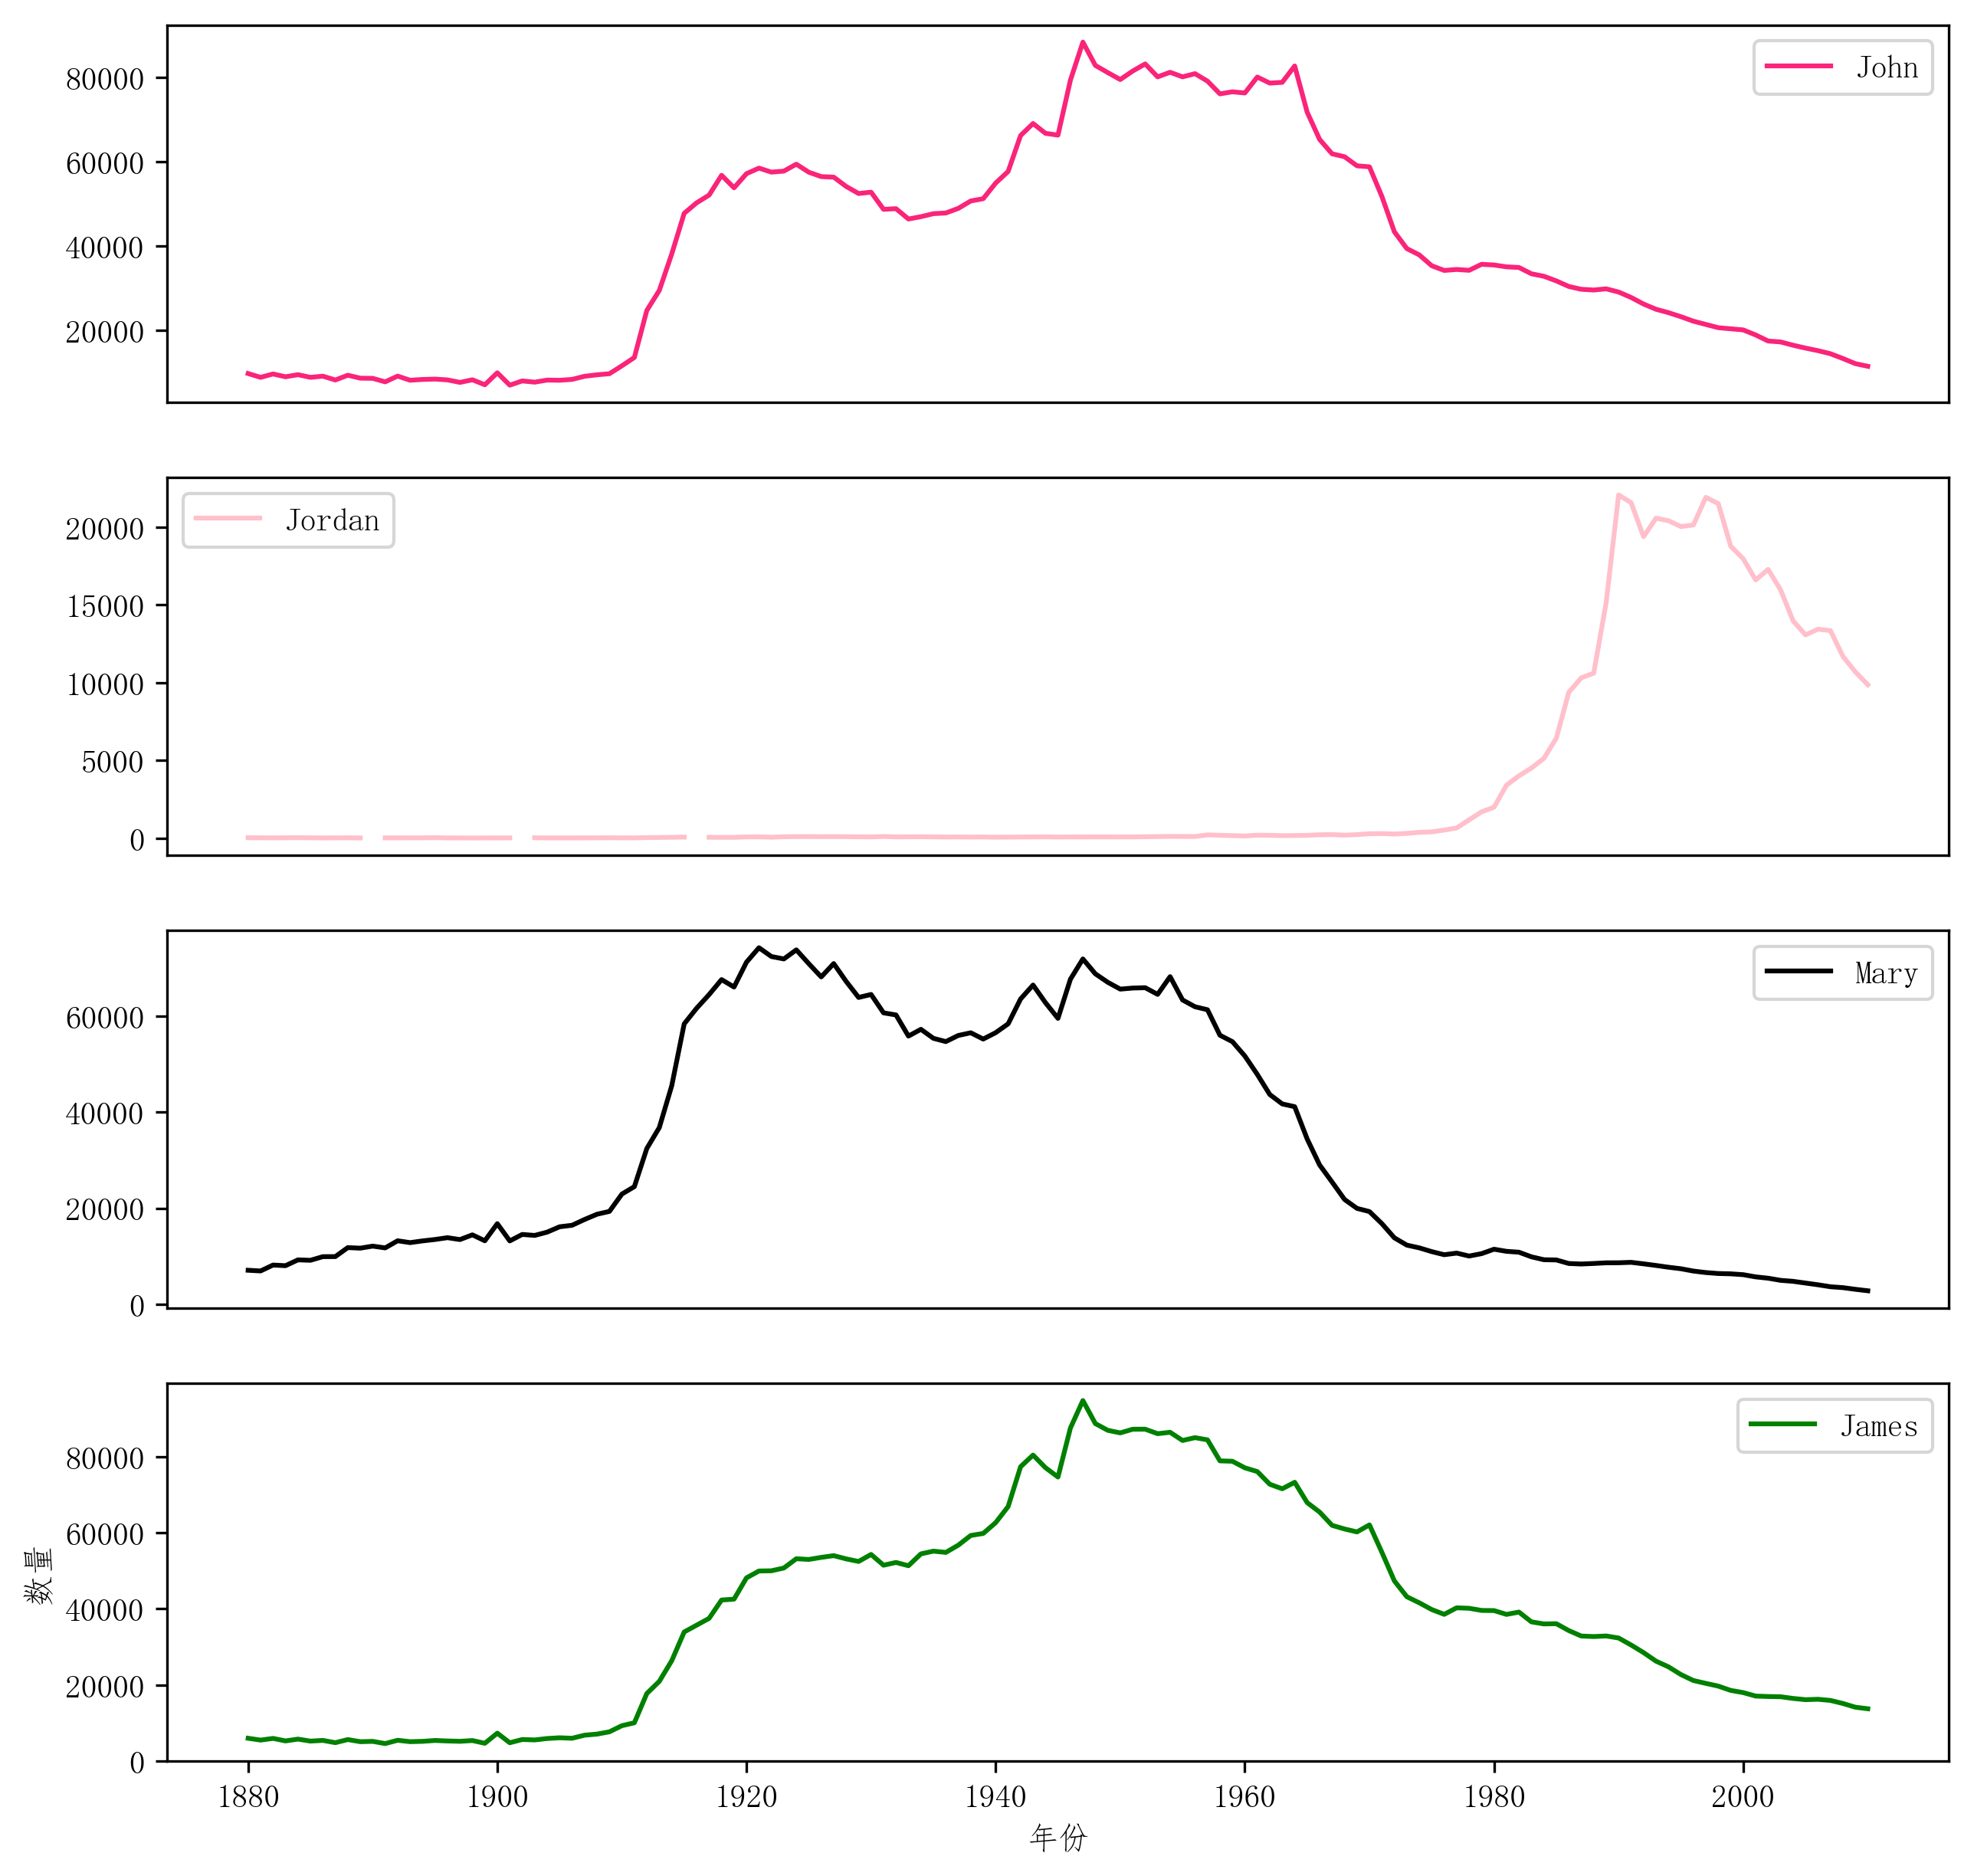

In [53]:
#将前1000个名字分为男女两个部分
boys=top1000[top1000.sex=='M']
girls=top1000[top1000.sex=='F']

#生成按year和name统计的总出生透视表
total_births=top1000.pivot_table('births',index='year',columns='name',aggfunc=sum)

#根据一些名字绘制曲线图
fig=plt.figure(figsize=(10,10))
subset=total_births[['John','Jordan','Mary','James']]
ax1=fig.add_subplot(411)
subset['John'].plot(kind='line',color='#FA2479')
plt.xticks([])#去掉横坐标刻度
plt.xlabel('')#去掉横坐标名称
plt.legend(labels = ['John'], loc = 'best')
ax1=fig.add_subplot(412)
subset['Jordan'].plot(kind='line',color='pink')
plt.legend(labels = ['Jordan'], loc = 'best')
plt.xticks([])
plt.xlabel('')
ax1=fig.add_subplot(413)
subset['Mary'].plot(kind='line',color='black')
plt.legend(labels = ['Mary'], loc = 'best')
plt.xticks([])
plt.xlabel('')
ax1=fig.add_subplot(414)
subset['James'].plot(kind='line',color='green')
plt.legend(labels = ['James'], loc = 'best')
plt.xlabel('年份')
plt.ylabel('数量')
plt.savefig('haha.jpg')
plt.show()

c:\python36\install\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
c:\python36\install\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
c:\python36\install\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


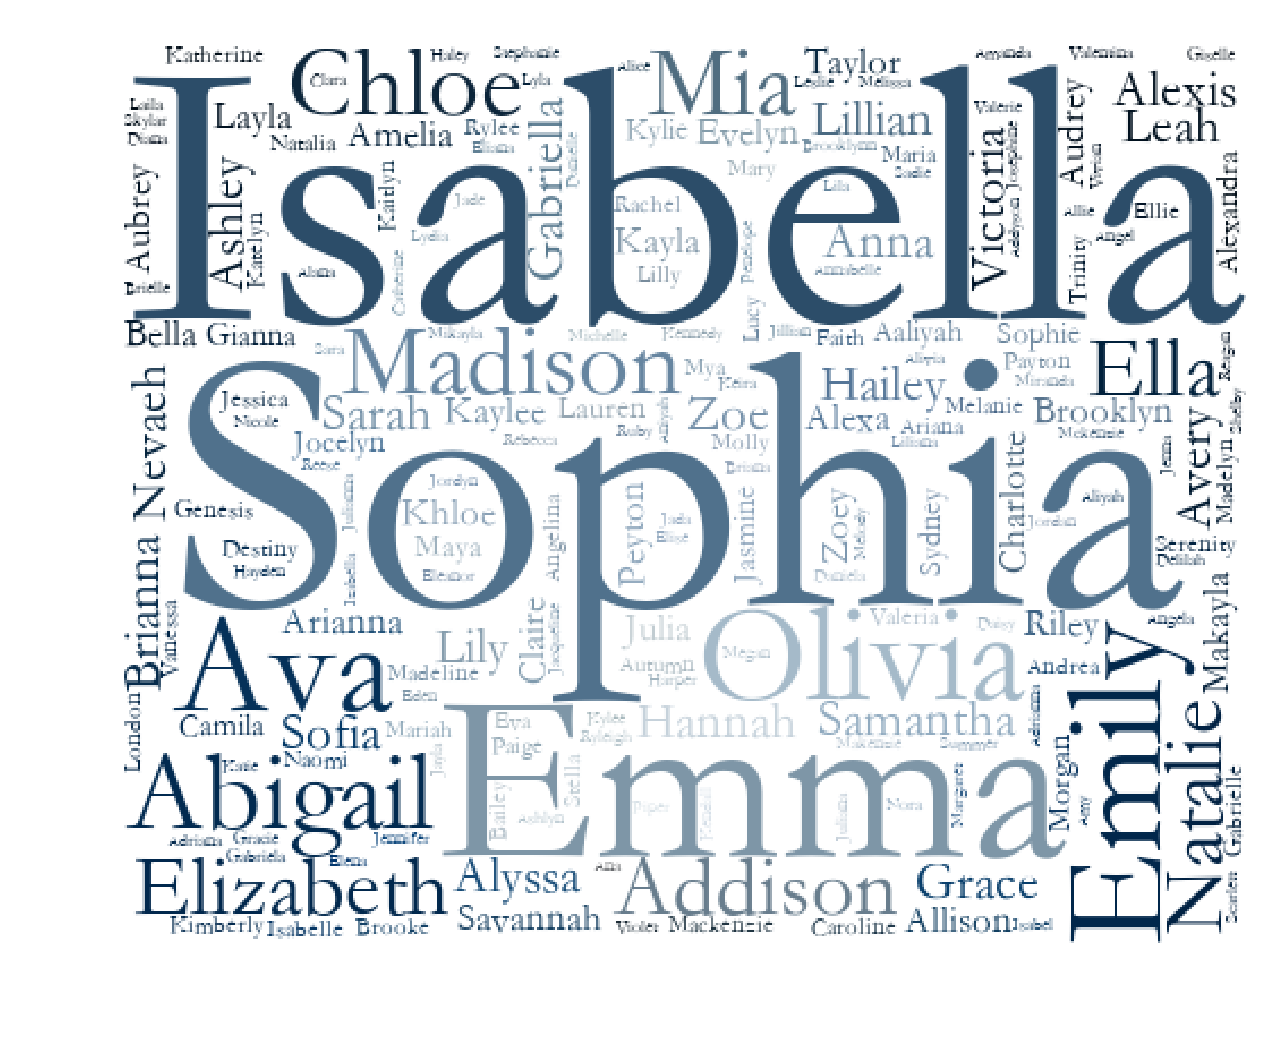

In [66]:
#生成2010男女姓名词云

import jieba
from scipy.misc import imread  # 这是一个处理图像的函数
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter


boy2010=names[names['year']==2010][names['sex']=='M']
girl2010=names[names['year']==2010][names['sex']=='F']
#boy2010['name']
girl2010['name']
data_str = ' '.join(girl2010['name'])
words_list = []
word_generator = jieba.cut_for_search(data_str)#搜索引擎模式
for word in word_generator:
    words_list.append(word)
words_list = [k for k in words_list if len(k) > 1]
back_color = imread('C:/Users/TTT/Desktop/7/w.jpg')  # 解析该图片
wc = WordCloud(background_color='white',  # 背景颜色
               max_words=200,  # 最大词数
               mask=back_color,  # 以该参数值作图绘制词云，这个参数不为空时，width和height会被忽略
               max_font_size=300,  # 显示字体的最大值
               font_path="C:/Windows/Fonts/STFANGSO.ttf",  # 解决显示口字型乱码问题，可进入C:/Windows/Fonts/目录更换字体
               random_state=42,  # 为每个词返回一个PIL颜色
               )
data_count = Counter(words_list)#字典的子类，给hashtable类对象计数
wc.generate_from_frequencies(data_count)#根据词出现的频率生成词云，词的字体大小表现了其频率大小。
# 基于彩色图像生成相应彩色
image_colors = ImageColorGenerator(back_color)
# 绘制结果
plt.figure()
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis('off')
plt.savefig('c2.png', dpi=500)
plt.show()

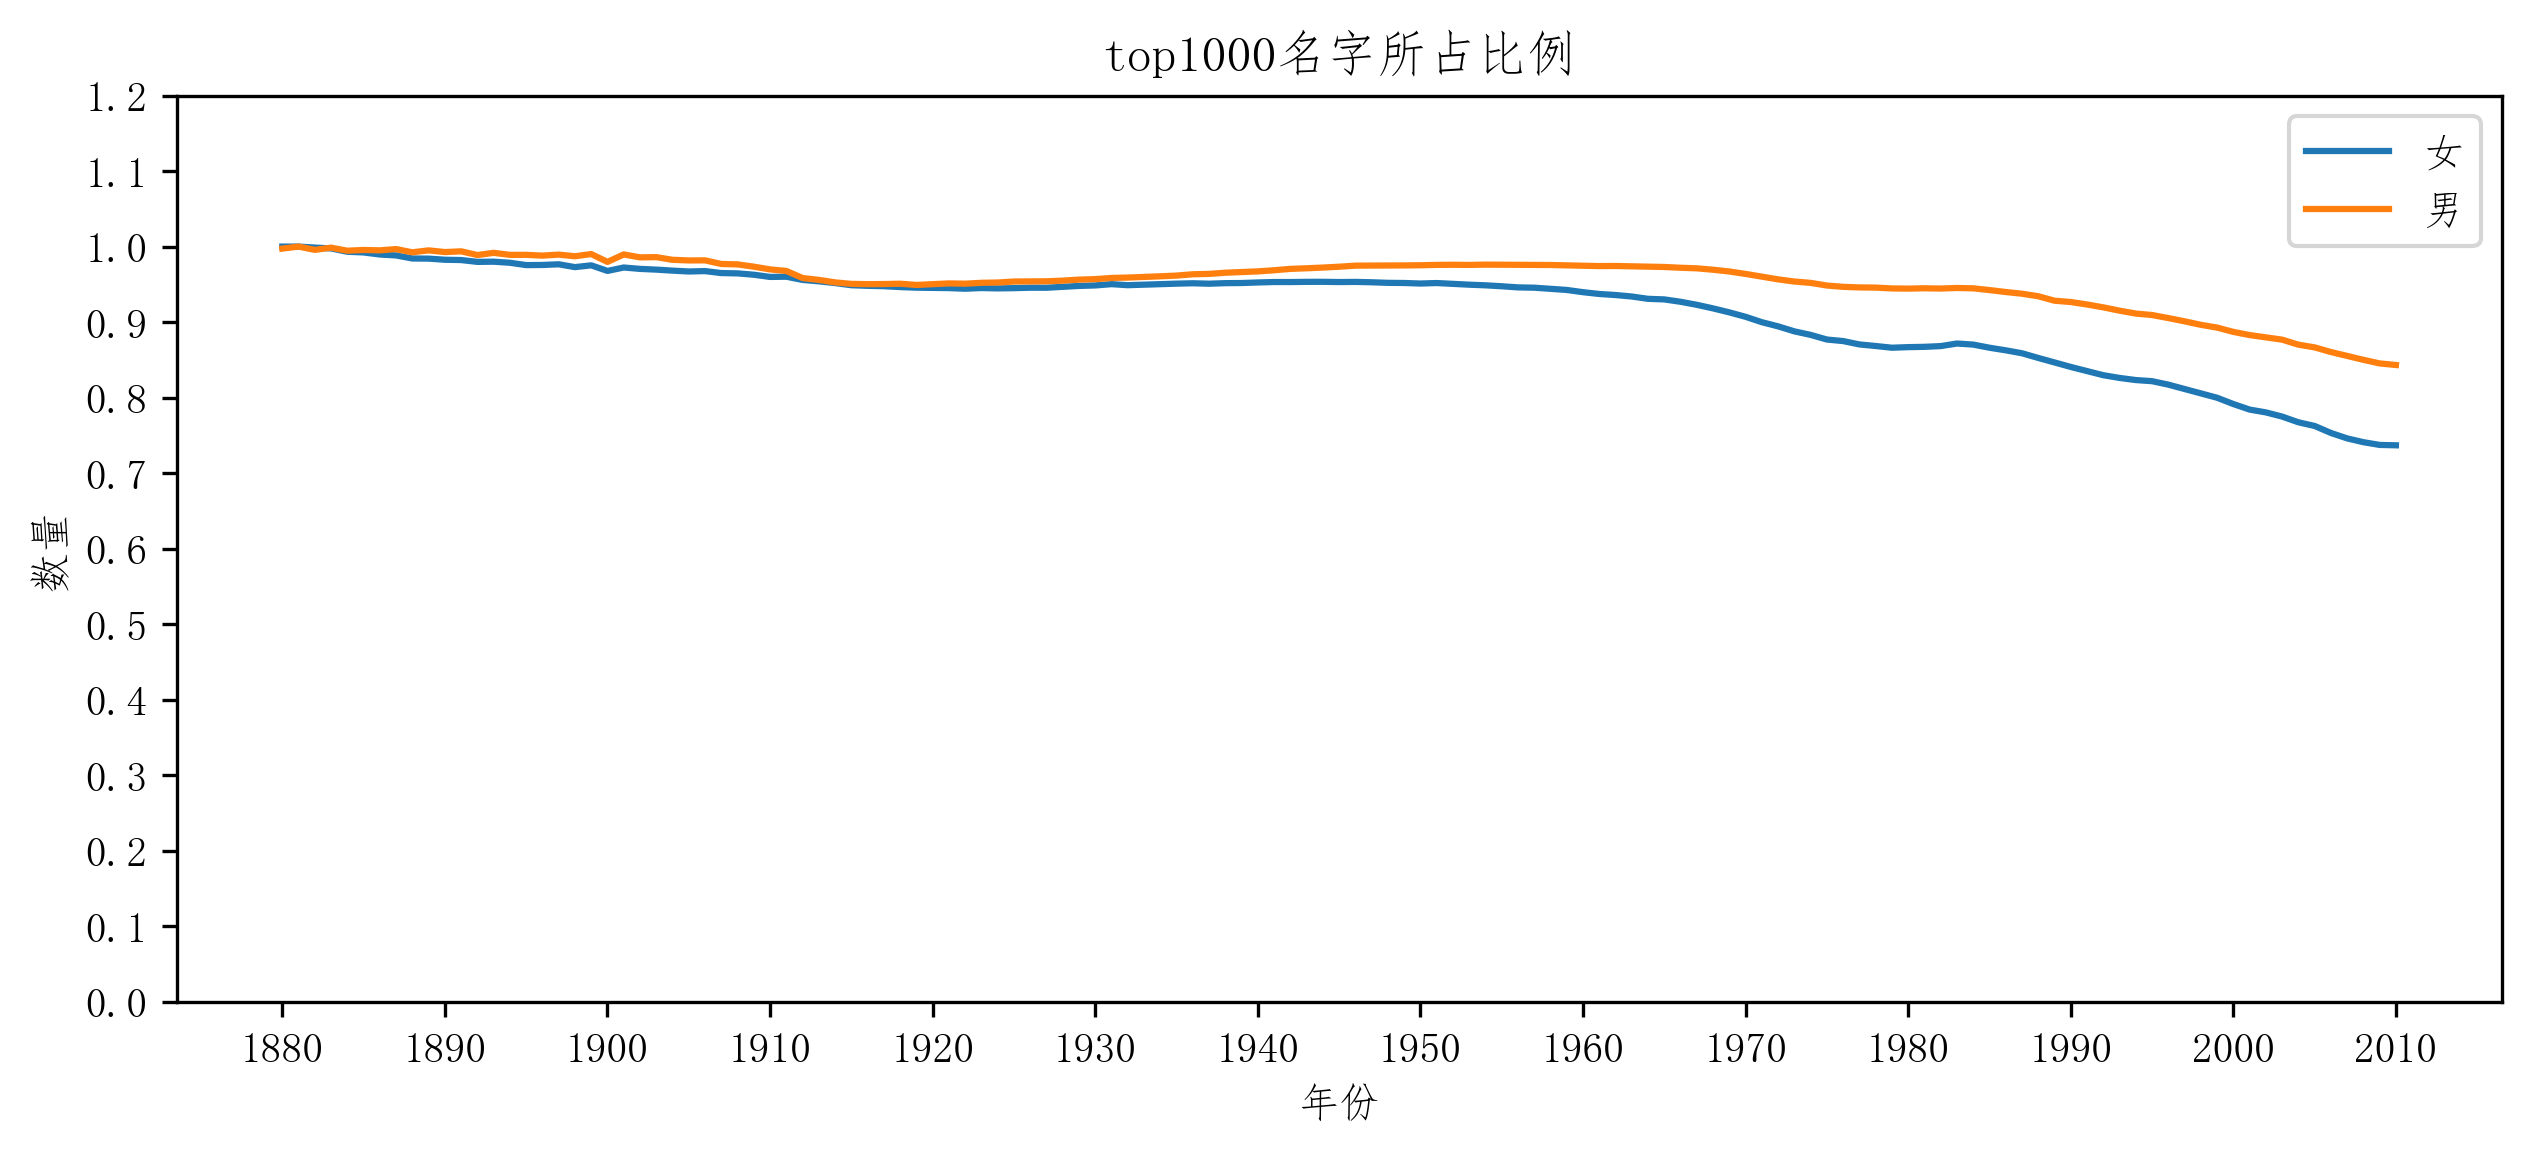

In [69]:
#计算最流行的1000个名字所占的比例，按year和sex进行聚合
table=top1000.pivot_table('prop',index='year',columns='sex',aggfunc=sum)
table.plot(kind='line')
plt.xticks(range(1880, 2020, 10))
plt.yticks(np.linspace(0, 1.2, 13))
plt.title(u"top1000名字所占比例")
plt.legend(labels = ['女', '男'], loc = 'best')
plt.xlabel('年份')
plt.ylabel('数量')
plt.show()

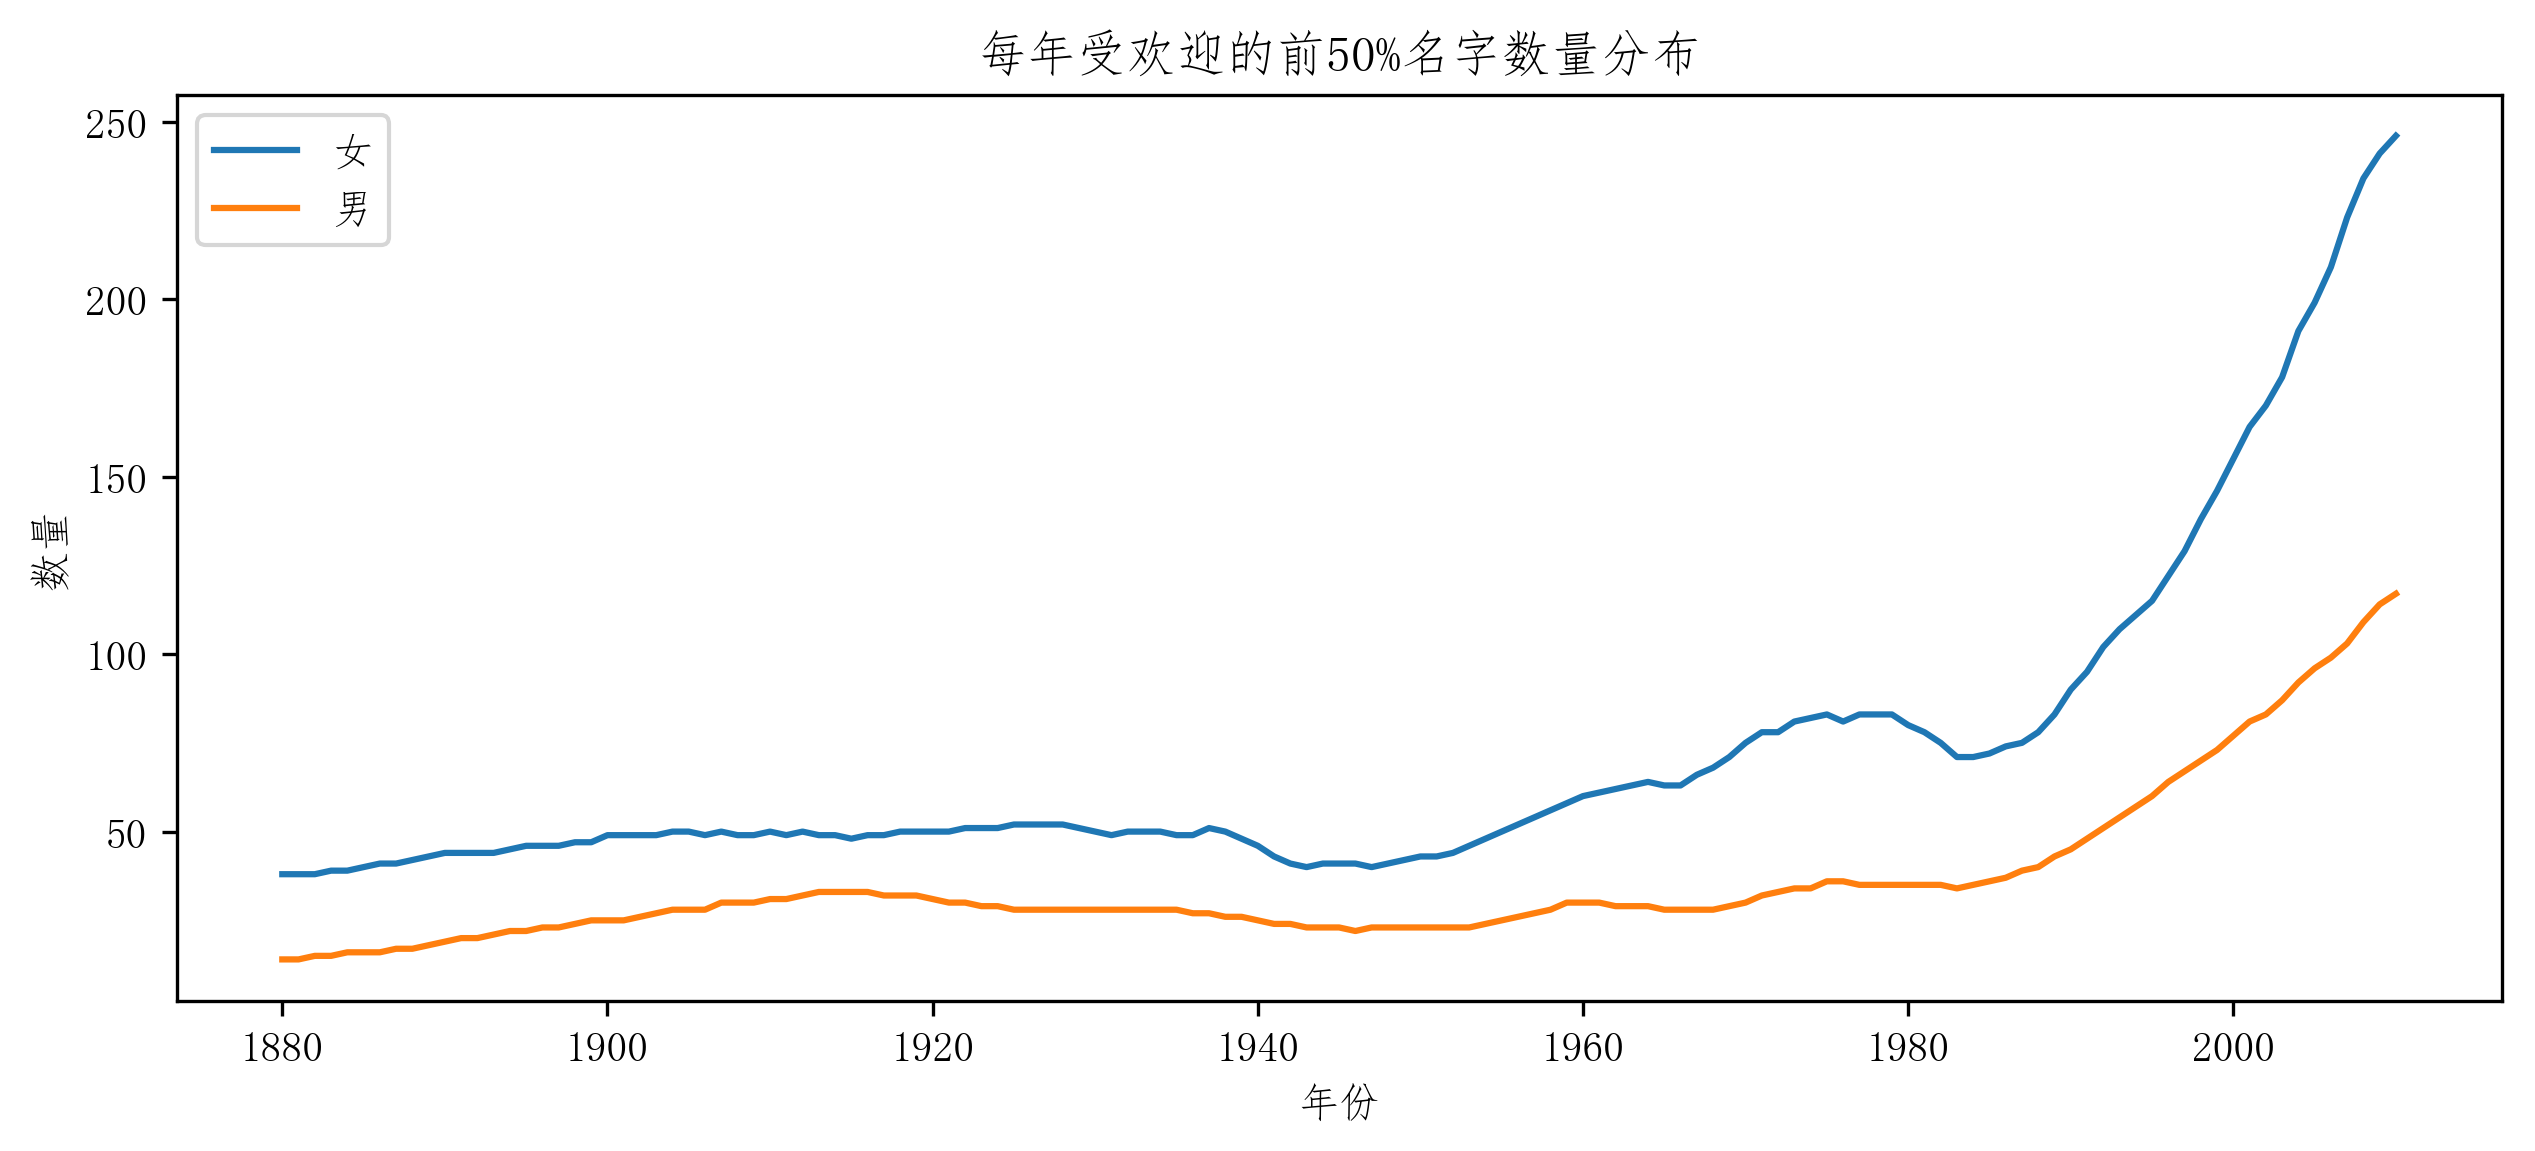

In [72]:
#计算占总出生人数前50%的不同名字的数量并绘图
def get_quantile_count(group,q=0.5):
    group=group.sort_values(by='prop',ascending=False)
    return group.prop.cumsum().values.searchsorted(q)+1

diversity=top1000.groupby(['year','sex']).apply(get_quantile_count)
diversity=diversity.unstack('sex')
diversity.plot(kind='line')
plt.title(u'每年受欢迎的前50%名字数量分布')
plt.legend(labels = ['女', '男'], loc = 'best')
plt.xlabel('年份')
plt.ylabel('数量')
plt.show()

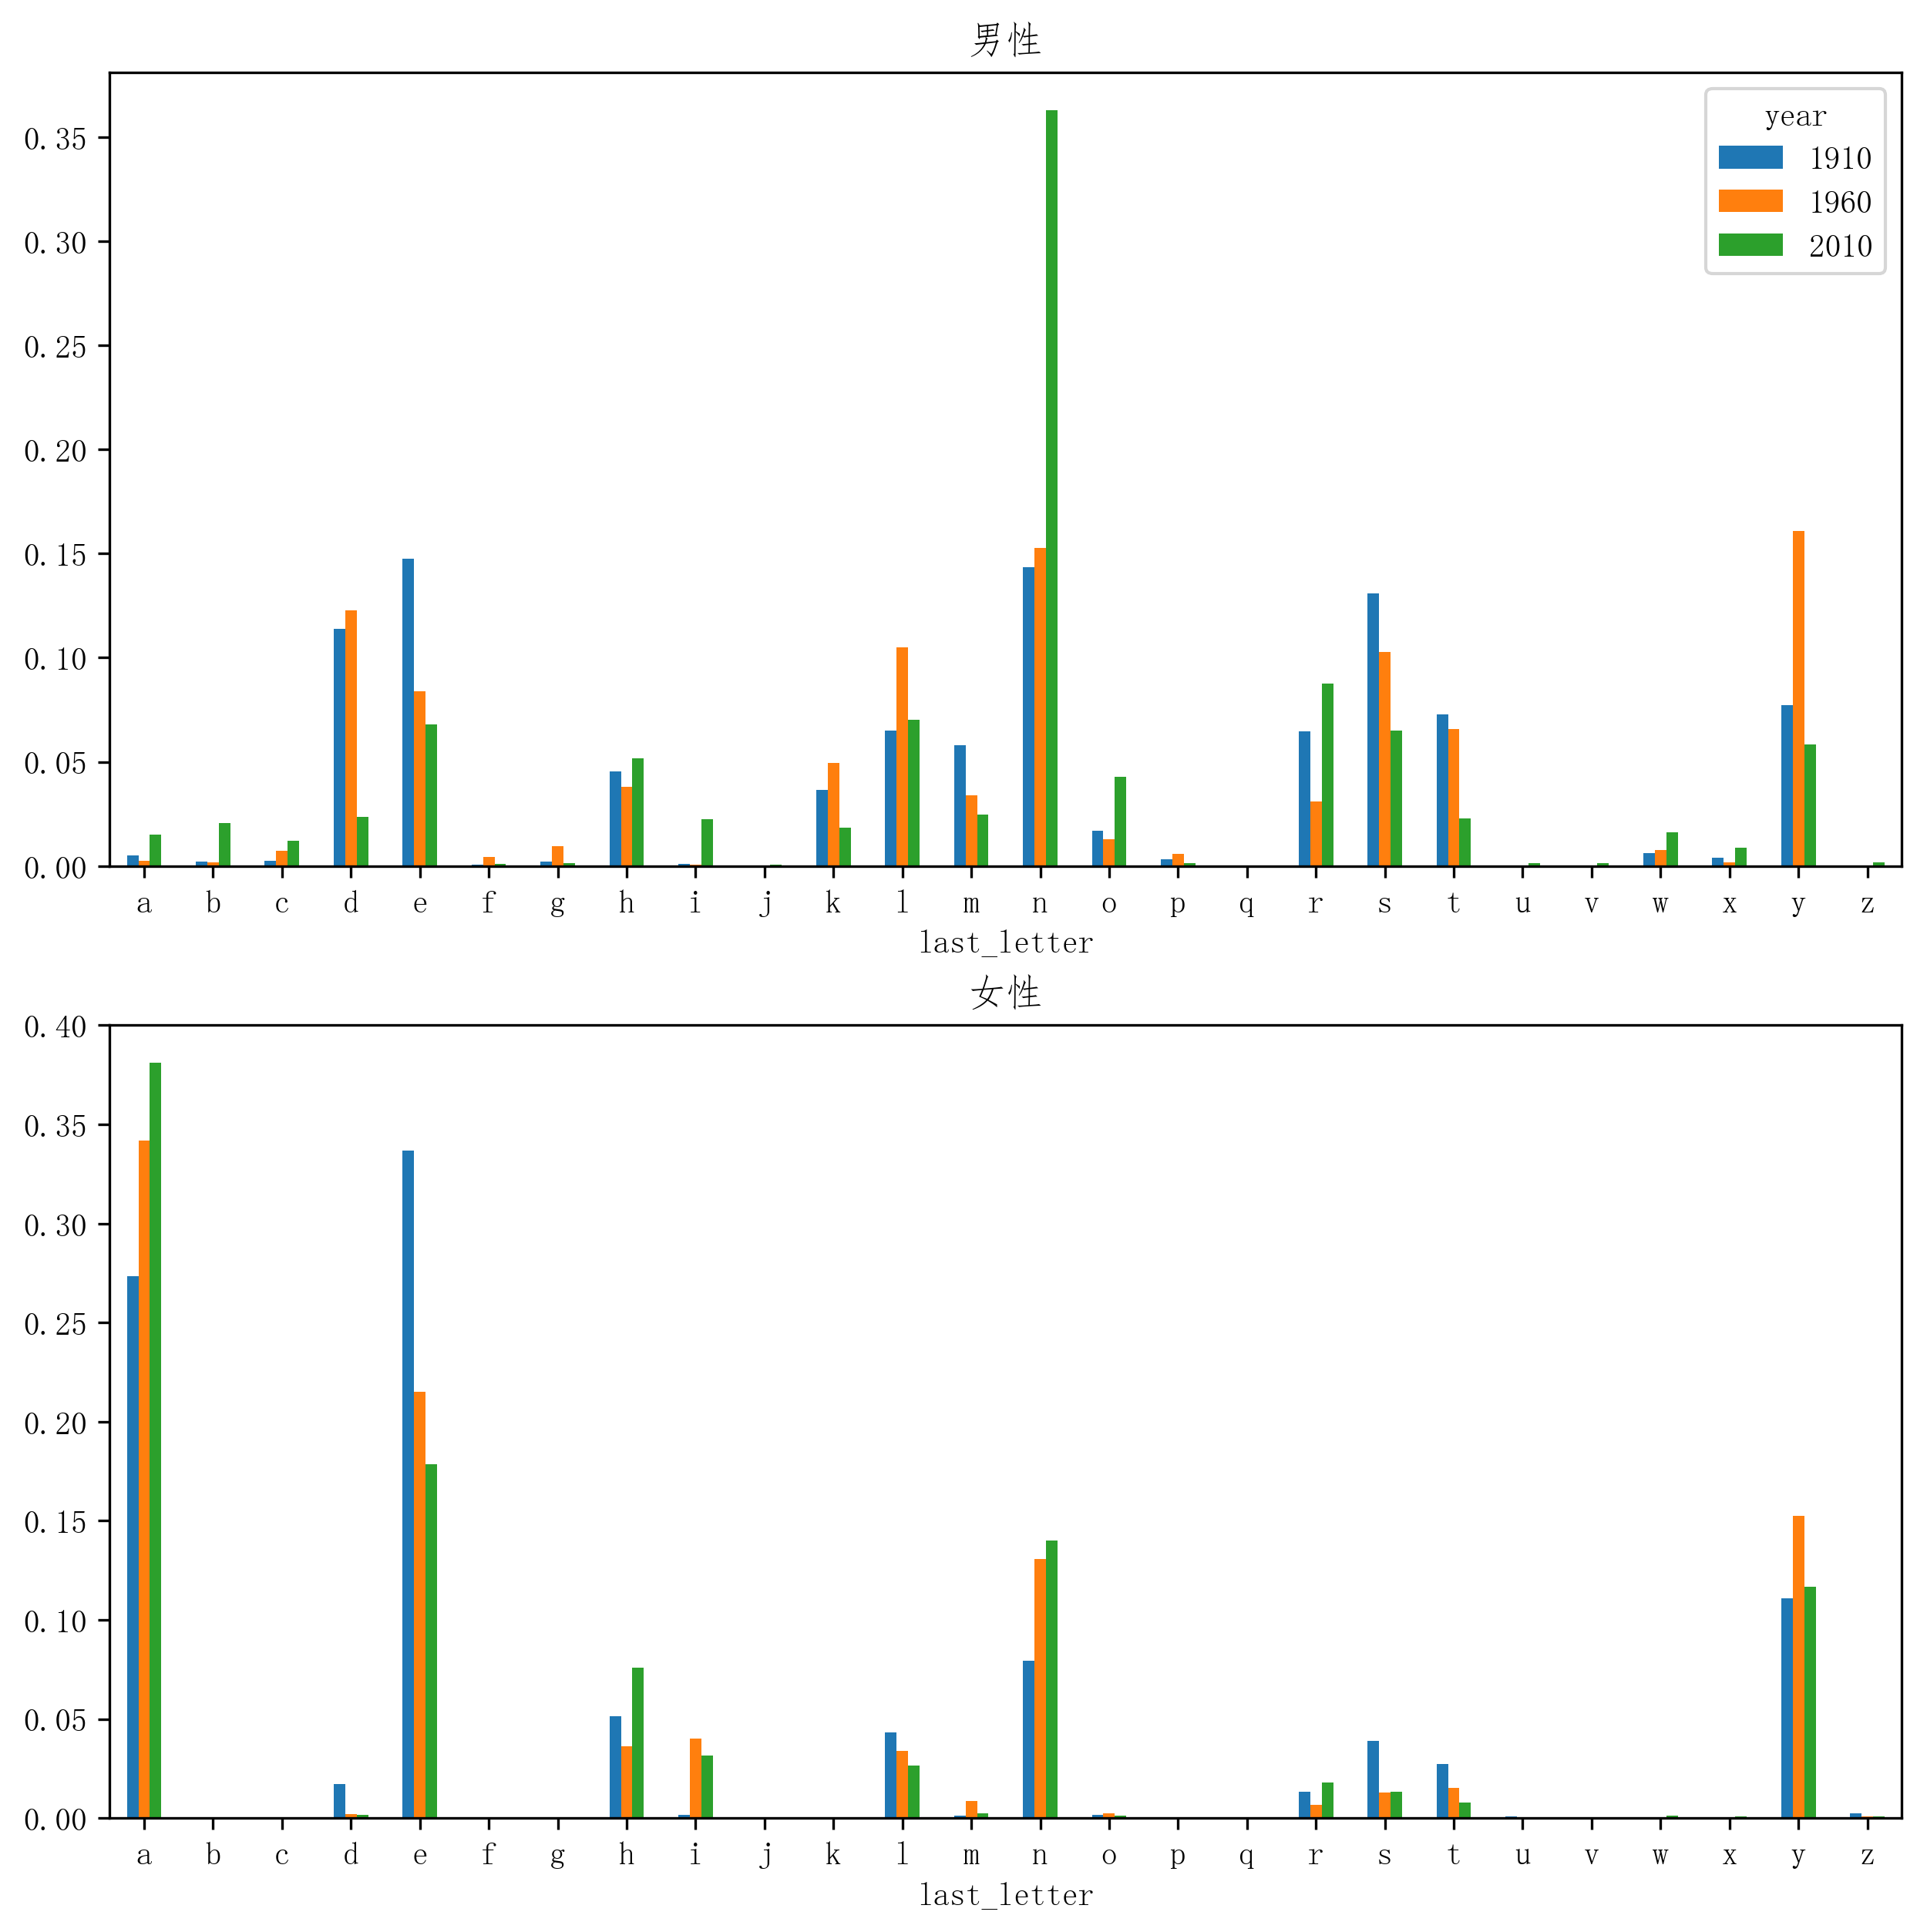

In [87]:
#观察名字当中最后一个字母的变化分布图
get_last_letter=lambda x:x[-1]
last_letters=names.name.map(get_last_letter)
last_letters.name='last_letter'
table=names.pivot_table('births',index=last_letters,columns=['sex','year'],
                       aggfunc=sum)
subtable=table.reindex(columns=[1910,1960,2010],level='year')
letter_prop=subtable/subtable.sum()
fig,axes=plt.subplots(2,1,figsize=(10,10))
letter_prop['M'].plot(kind='bar',rot=0,ax=axes[0],title='男性')
letter_prop['F'].plot(kind='bar',rot=0,ax=axes[1],title='女性',legend=False)
plt.show()

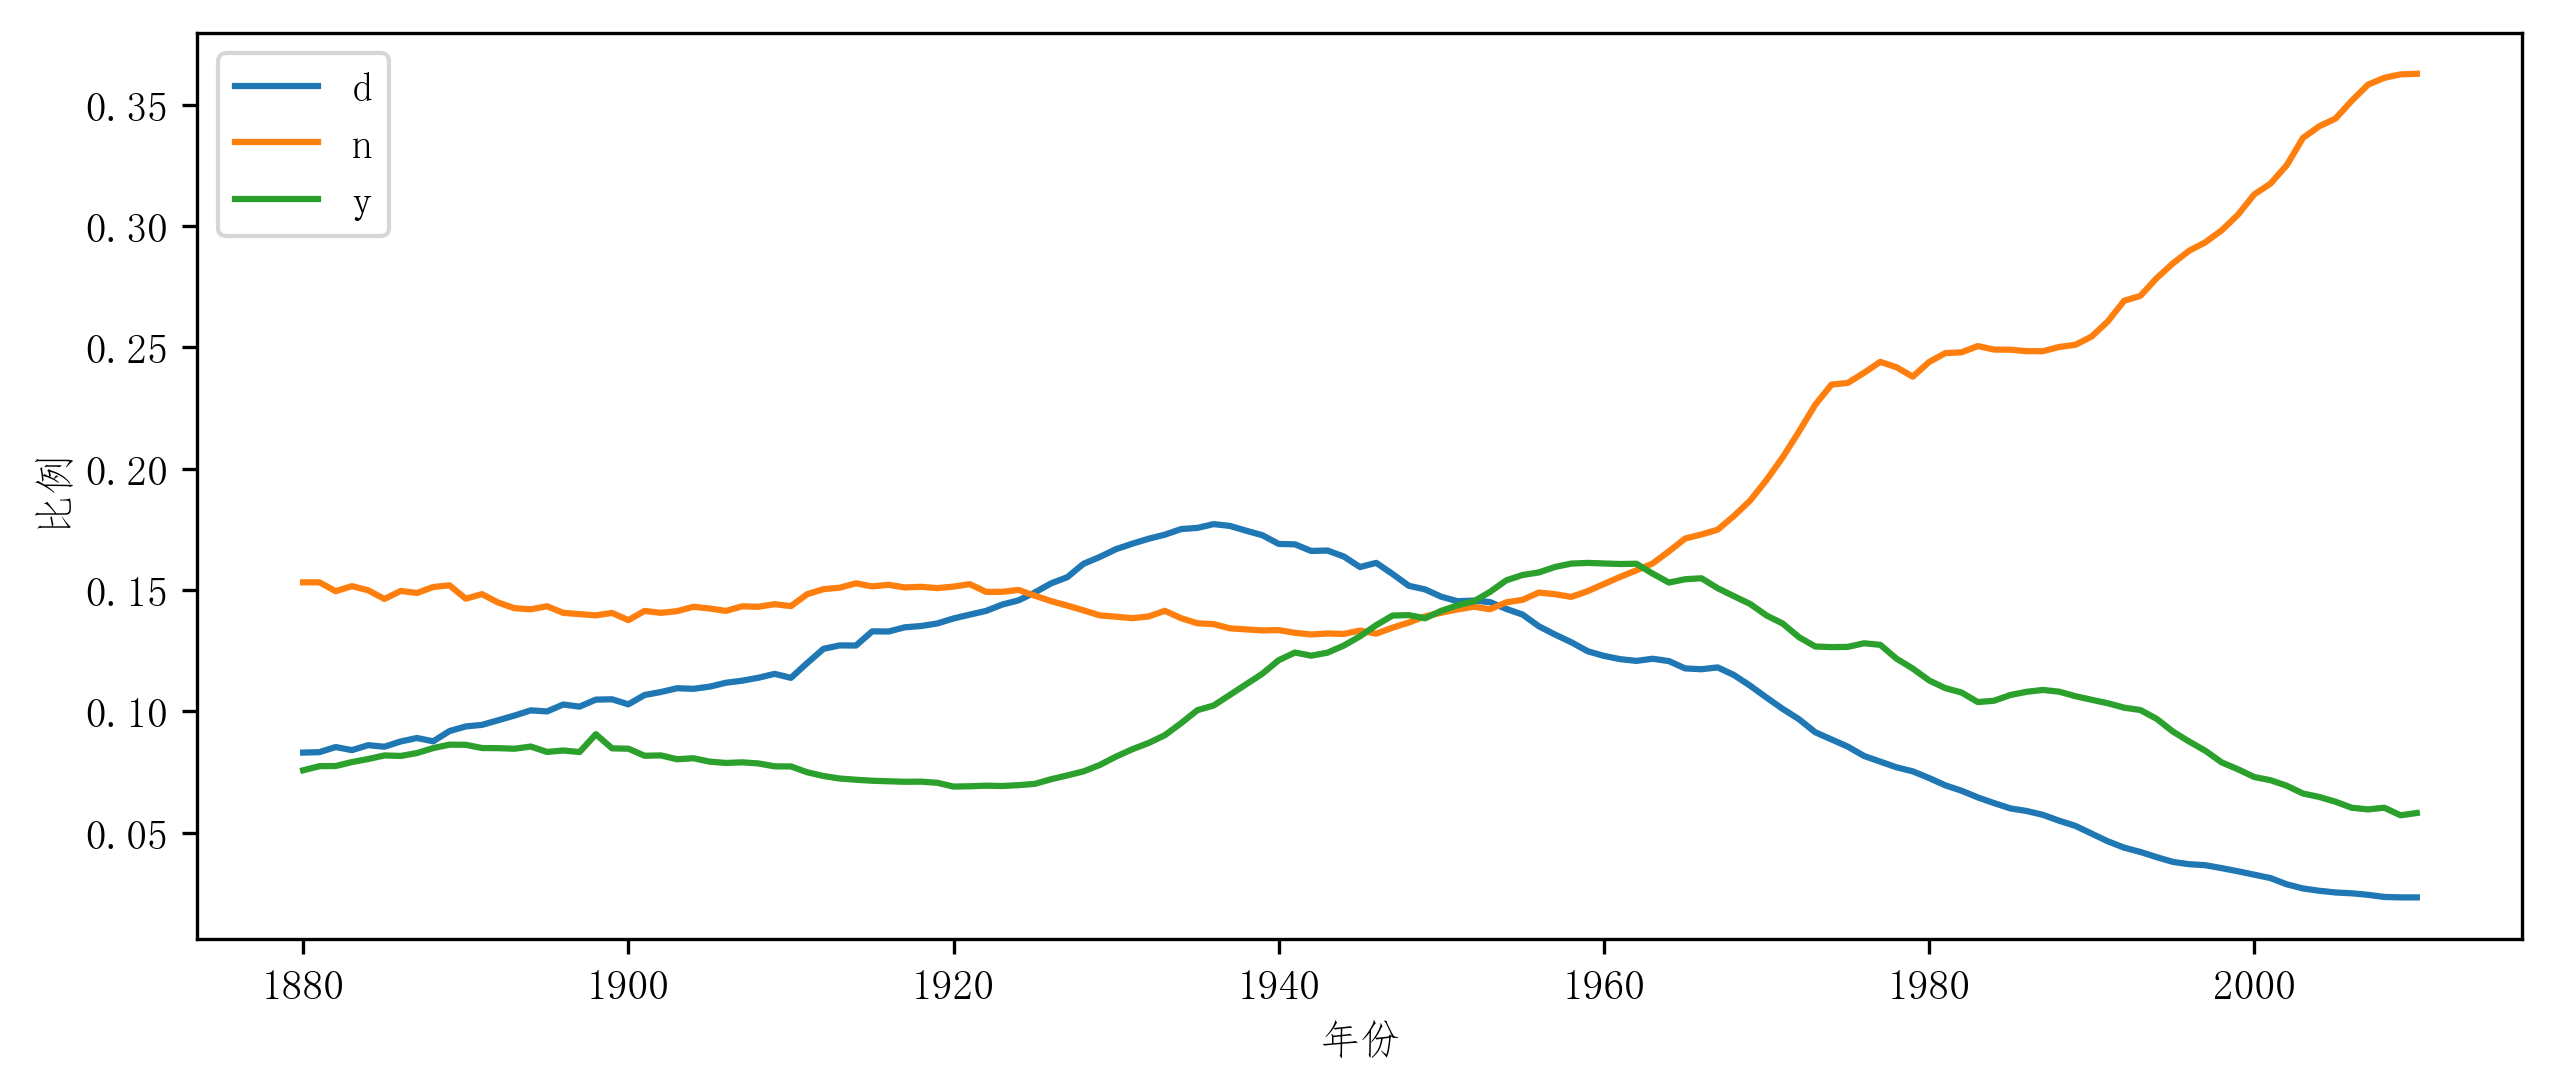

In [88]:
#观察以dny单个字母结尾的姓名分布图
letter_prop=table/table.sum()
dny_ts=letter_prop.loc[['d','n','y'],'M'].T
dny_ts.plot()
plt.legend(labels = ['d', 'n','y'], loc = 'best')
plt.xlabel('年份')
plt.ylabel('比例')
plt.show()

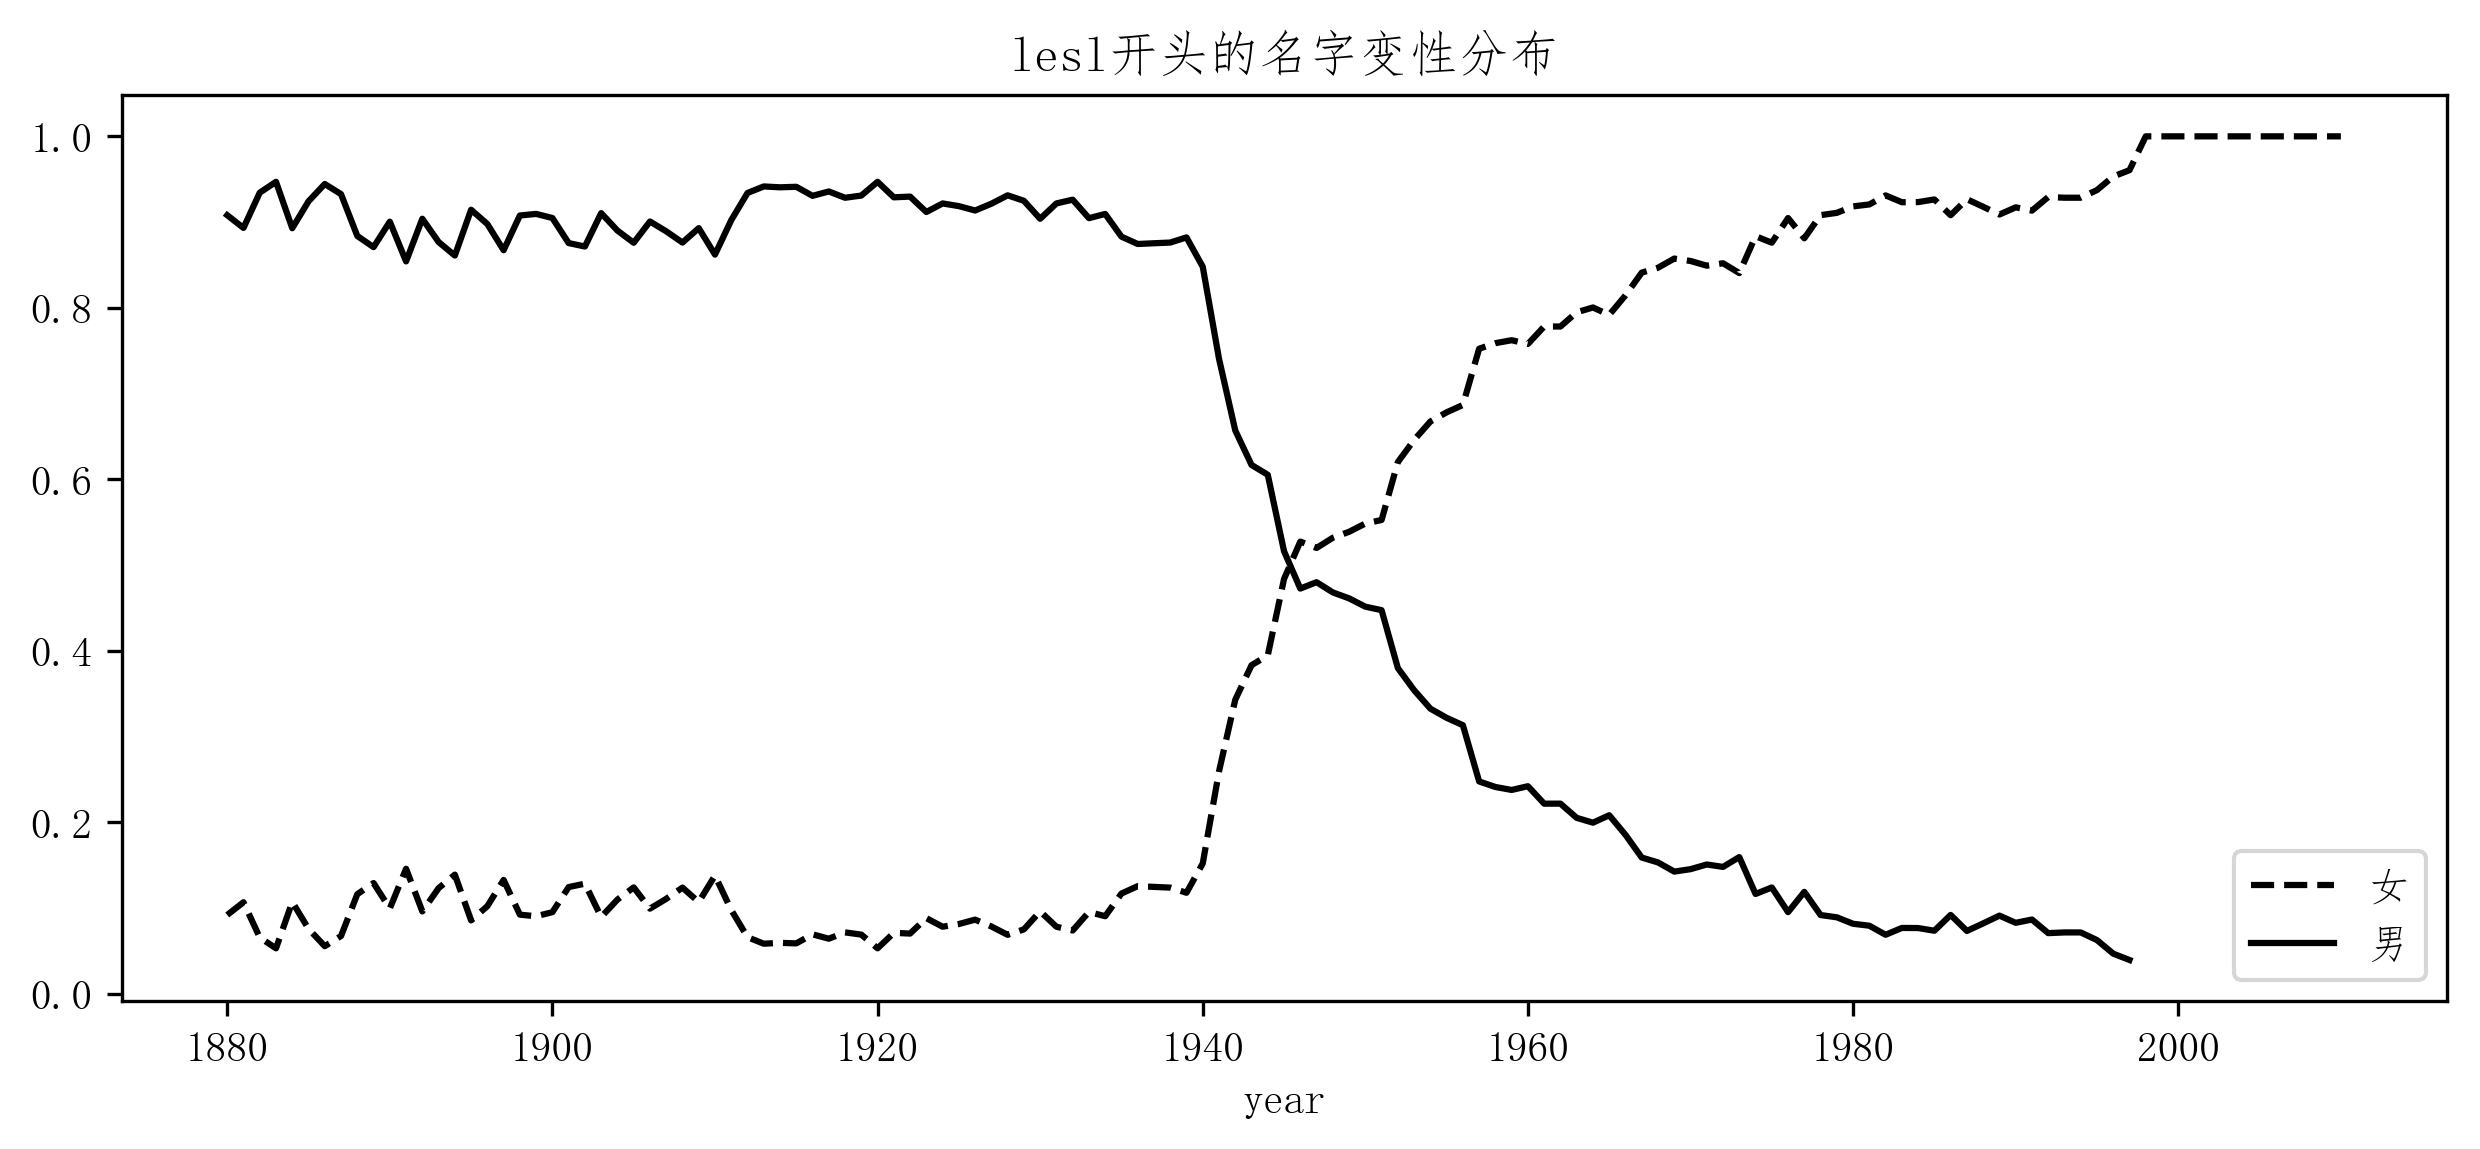

In [90]:
#名字变性的情况(这里以“lesl”开头的为例)
all_names=pd.Series(top1000.name.unique())
lesley_like=all_names[all_names.str.lower().str.contains('lesl')]
filtered=top1000[top1000.name.isin(lesley_like)]
table=filtered.pivot_table('births',index='year',columns='sex',aggfunc='sum')
table=table.div(table.sum(1),axis=0)
table.plot(style={'M':'k-','F':'k--'})
plt.title(u"lesl开头的名字变性分布")
plt.legend(labels = ['女', '男'], loc = 'best')
plt.show()